In [58]:
## load dataset

import pandas as pd
import numpy as np

## keras dependencies
from keras import backend as K

from keras.layers import Conv1D, Dense, Input, Lambda, LSTM
from keras.layers.merge import concatenate
from keras.layers import Bidirectional, Lambda, TimeDistributed
from keras.layers.embeddings import Embedding

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing import sequence
import _pickle as cPickle

from keras.layers import Concatenate, Input, MaxPooling1D
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences # To make vectors the same size. 
# from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPool1D, MaxPool1D
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, CSVLogger, EarlyStopping
import matplotlib.pyplot as plt


fake_df=pd.read_csv('gossipcop_fake.csv')
legit_df=pd.read_csv('gossipcop_real.csv')

In [59]:
## remove stop words
import nltk
import re, string
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))

fake_df['title'] = list(map(' '.join, fake_df['title'].apply(lambda x: [item for item in x.lower().split() if item not in stop])))
legit_df['title'] = list(map(' '.join, legit_df['title'].apply(lambda x: [item for item in x.lower().split() if item not in stop])))

##
fakes = [s.strip().lower() for s in fake_df.title]
legits = [s.strip().lower() for s in legit_df.title]

## preprocessing utilities
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

## clean text
x_text = fakes + legits
x_text = [clean_str(sent) for sent in x_text]

## 
# Generate labels
# legits_labels = [[0, 1] for _ in legits]
# fakes_labels = [[1, 0] for _ in fakes]
# y = np.concatenate([legits_labels, fakes_labels], 0)

labels = [0 for _ in range(len(fakes))] + [1 for _ in range(len(legits))]
labels = to_categorical(labels)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jshayi2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.layers import Embedding
from keras import optimizers
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split

In [61]:
## parameter
MAX_NUM_WORDS   = 30000
MAX_SEQ_LENGTH = 150
hidden_size = 150 #Has to be same as EMBEDDING_DIM
lstm_size = 100
num_steps = 150
num_epochs = 30
batch_size = 64
#Hyperparams for CNN
kernel_sizes = [3,4,5]
filter_size = 128
embedding_dims=300
val_size= 0.2

In [62]:
## tokenize for word based embedding
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_text)
sequences = tokenizer.texts_to_sequences(x_text)
vocab_dict=tokenizer.word_index
data   = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

In [63]:
max_features = len(vocab_dict)+1
vocab_length = len(vocab_dict.keys())

In [64]:
random_state = np.random.randint(234)
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=val_size, random_state=random_state)

In [65]:
## loading glovec
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    embeddings_index = {}
    f = open(gloveFile, encoding='utf8')
    for line in f:
        values = line.split()
        word = ''.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

glove_model = loadGloveModel('glove.6B.300d.txt')

def build_glove_embedding_layers():
    embed_matrix=np.zeros((max_features, embedding_dims))
    for word, indx in tokenizer.word_index.items():
        if indx >= max_features:
            continue
        if word in glove_model:
            embed_vec=glove_model[word]
            if embed_vec is not None:
                embed_matrix[indx]=embed_vec
    return embed_matrix

embedding_weights=build_glove_embedding_layers()

Loading Glove Model


### CNN model for new dataset

In [66]:
import keras

kernel_arr = []
statement_input = Input(shape=(num_steps,), dtype='int32', name='main_input')
embed_sequences = Embedding(vocab_length+1,embedding_dims,weights=[embedding_weights],input_length=num_steps,trainable=False)(statement_input) #Preloaded glove embeddings

for kernel in kernel_sizes:
    x_1 = Conv1D(filters=filter_size,kernel_size=kernel, 
                 padding="same", activation="relu", strides=1)(embed_sequences)
    x_1 = MaxPool1D(3)(x_1)
    x_flat = Flatten()(x_1)
    x_drop = Dropout(0.85)(x_flat)
    kernel_arr.append(x_flat)

conv_ins = keras.layers.concatenate(kernel_arr)
conv_ins = Dropout(0.85)(conv_ins)
conv_ins = Dense(128, activation='relu')(conv_ins)

## add multi convolutional layer
l_conv1 = Conv1D(128,3,activation="relu", padding="valid", strides=1)(embed_sequences)
l_pool1 = MaxPooling1D(3)(l_conv1)
l_conv2 = Conv1D(128, 3, activation="relu")(l_pool1)
l_pool2 = MaxPooling1D(3)(l_conv2)
# l_conv3 = Conv1D(128,3,activation="relu")(l_pool2)
# l_pool3 = MaxPool1D(3)(l_conv3)
l_flat = Flatten()(l_pool2)
conv_in1 = Dropout(0.85)(l_flat)
conv_in1 = Dense(128, activation='relu')(conv_in1)

## do merge
conv_merged= keras.layers.concatenate([conv_ins, conv_in1])

# #Meta input
# meta_input = Input(shape=(x_train_metadata.shape[1],), name='aux_input')
# x_drop = Dropout(0.9)(meta_input)
# x_meta = Dense(100, activation='relu')(x_drop)
# x = keras.layers.concatenate([conv_merged, x_meta])


main_output = Dense(2, activation='softmax', name='main_output')(conv_merged)
model_hybird = Model(inputs=[statement_input], outputs=[main_output])

#************************************************************************#
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.2)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)


model_hybird.compile(optimizer=sgd,
                    loss='categorical_crossentropy',
                    metrics=['categorical_accuracy'])

model_hybird.summary()

##
tb = TensorBoard()
csv_logger = keras.callbacks.CSVLogger('training.log')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
filepath= "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor='val_categorical_accuracy', 
                                             verbose=1, save_best_only=True, mode='max')

history22= model_hybird.fit(X_train,
                           y_train,epochs=20, batch_size=64,
                           validation_data=(X_val,y_val),
                           callbacks=[tb,csv_logger,checkpoint, es])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 150, 300)     5742600     main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 148, 128)     115328      embedding_13[0][0]               
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 150, 128)     115328      embedding_13[0][0]               
__________________________________________________________________________________________________
conv1d_33 

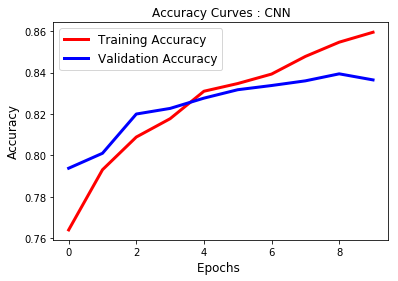

C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


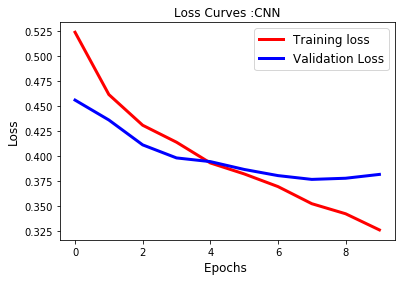

In [67]:
accu_curve=plt.figure()
plt.plot(history22.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history22.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Accuracy Curves : CNN',fontsize=12)
# accu_curve.savefig('accuracy_cnn_improved_v1.6.best.png')
plt.show()
##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^##
loss_curve = plt.figure()
plt.plot(history22.history['loss'],'r',linewidth=3.0)
plt.plot(history22.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves :CNN',fontsize=12)
# loss_curve.savefig('loss_cnn_improved_v1.6.best.png')
loss_curve.show()

### C-LSTM model (new dataset)


In [68]:
## C-LSTM model implementation (trail version)
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import LSTM, Bidirectional

statement_input = Input(shape=(num_steps,), dtype='int64', name='main_input')
# embed_layer = Embedding(output_dim=hidden_size, input_dim=vocab_length+1, input_length=num_steps)(statement_input) #Train embeddings from scratch
embed_layer = Embedding(vocab_length+1,embedding_dims,weights=[embedding_weights],input_length=num_steps,trainable=False)(statement_input) #Preloaded glove embeddings
l_lstm = Bidirectional(LSTM(200, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(embed_layer)
# lstm_pool = GlobalMaxPool1D()(l_lstm)

## let's add convolutional layer on it
l_conv1 = Conv1D(128, 3, activation="relu")(l_lstm)
l_pool1 = MaxPooling1D(3)(l_conv1)
l_conv2 = Conv1D(128,3,activation="relu")(l_pool1)
l_pool2 = MaxPool1D(3)(l_conv2)
l_flat = Flatten()(l_pool2)
l_drop = Dropout(0.85)(l_flat)
conv_in = Dense(hidden_size, activation="relu")(l_drop)

'''
### metadata
meta_input = Input(shape=(x_train_metadata.shape[1],), name='aux_input')
x_meta_hidden = Dense(64, activation='relu')(meta_input)
x_meta_reg = Dropout(0.6)(x_meta_hidden)
conv_final = keras.layers.concatenate([conv_in, x_meta_reg])
'''

model_output = Dense(2, activation='softmax', name='main_output')(conv_in)
model_CLSTM = Model(inputs=[statement_input], outputs=[model_output])

## compile model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_CLSTM.compile(optimizer=sgd,
                    loss='categorical_crossentropy',
                    metrics=['categorical_accuracy'])

model_CLSTM.summary()

tb = TensorBoard()
csv_logger = keras.callbacks.CSVLogger('training.log')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
filepath= "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor='val_categorical_accuracy', 
                                             verbose=1, save_best_only=True, mode='max')

history_clstm = model_CLSTM.fit({'main_input': X_train},
                                {'main_output': y_train},epochs=num_epochs, batch_size=batch_size,
                                validation_data=({'main_input': X_val},{'main_output': y_val}),
                                callbacks=[tb,csv_logger,checkpoint, es])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 150)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 150, 300)          5742600   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 150, 400)          801600    
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 148, 128)          153728    
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 49, 128)           0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 47, 128)           49280     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 15, 128)           0         
__________

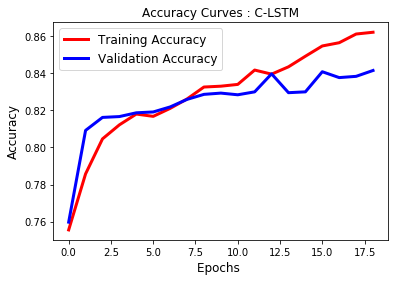

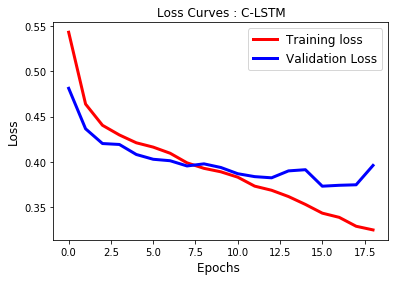

In [69]:
accu_curve=plt.figure()
plt.plot(history_clstm.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history_clstm.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Accuracy Curves : C-LSTM',fontsize=12)
# accu_curve.savefig('accuracy_clstm_improved_v1.4.4.png')
plt.show()
##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^##
loss_curve = plt.figure()
plt.plot(history_clstm.history['loss'],'r',linewidth=3.0)
plt.plot(history_clstm.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves : C-LSTM',fontsize=12)
# loss_curve.savefig('loss_clstm_improved_v1.4.4.png')
loss_curve.show()

### Recurrent Convolutional models (RCNN)

In [72]:
hidden_dim_1 = 128
hidden_dim_2 = 128

kernel_arr = []

statement_input = Input(shape=(num_steps,), dtype='int32', name='main_input')
embed_sequences = Embedding(vocab_length+1,embedding_dims,
                            weights=[embedding_weights],input_length=num_steps,
                            trainable=False)(statement_input)

L1 = Bidirectional(LSTM(hidden_dim_1, return_sequences=True))(embed_sequences)
L2 = TimeDistributed(Dense(hidden_dim_2, activation = "tanh"))(L1)

l_conv1 = Conv1D(128, 3, activation="relu")(L2)
l_pool1 = MaxPooling1D(3)(l_conv1)
l_conv2 = Conv1D(128,3,activation="relu")(l_pool1)
l_pool2 = MaxPool1D(3)(l_conv2)
pool_rnn = Lambda(lambda x: K.max(x, axis = 1), 
                  output_shape = (hidden_dim_2, ))(l_pool2)
# l_flat = Flatten()(pool_rnn)
l_drop = Dropout(0.7)(pool_rnn)
conv_in = Dense(hidden_size, activation="relu")(l_drop)

'''
### metadata
meta_input = Input(shape=(x_train_metadata.shape[1],), name='aux_input')
x_meta_hidden = Dense(64, activation='relu')(meta_input)
x_meta_reg = Dropout(0.6)(x_meta_hidden)
conv_final = keras.layers.concatenate([conv_in, x_meta_reg])

'''

model_output = Dense(2, activation='softmax', name='main_output')(conv_in)
model_RCNN = Model(inputs=[statement_input], outputs=[model_output])

## compile model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_RCNN.compile(optimizer=sgd,
                   loss='categorical_crossentropy',
                   metrics=['categorical_accuracy'])

model_RCNN.summary()

tb = TensorBoard()
csv_logger = keras.callbacks.CSVLogger('training.log')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
filepath= "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor='val_categorical_accuracy', 
                                             verbose=1, save_best_only=True, mode='max')

history_RCNN = model_RCNN.fit({'main_input': X_train},
                               {'main_output': y_train},epochs=30, batch_size=batch_size,
                               validation_data=({'main_input': X_val},{'main_output': y_val}),
                               callbacks=[tb,csv_logger,checkpoint, es])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 150)               0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 150, 300)          5742600   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 150, 256)          439296    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 150, 128)          32896     
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 148, 128)          49280     
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 49, 128)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 47, 128)           49280     
__________

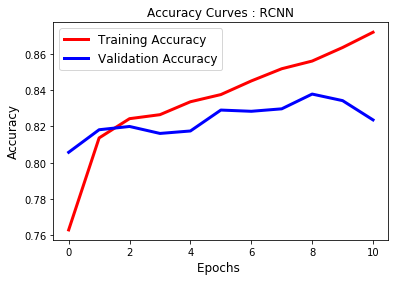

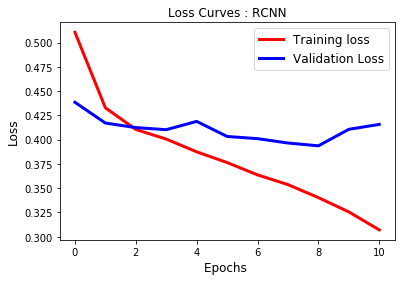

In [73]:
accu_curve=plt.figure()
plt.plot(history_RCNN.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history_RCNN.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Accuracy Curves : RCNN',fontsize=12)
# accu_curve.savefig('accuracy_clstm_improved_v1.4.4.png')
plt.show()
##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^##
loss_curve = plt.figure()
plt.plot(history_RCNN.history['loss'],'r',linewidth=3.0)
plt.plot(history_RCNN.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves : RCNN',fontsize=12)
# loss_curve.savefig('loss_clstm_improved_v1.4.4.png')
loss_curve.show()